<a href="https://colab.research.google.com/github/jbigham878/nflseasonmodeling/blob/main/NFL_Playoff_Results_by_Season_Stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Imports & Definitions**

In [21]:
# All imports in one place for convenience
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
from sklearn.linear_model import LogisticRegression
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from google.colab import auth
import gspread
from google.auth import default
#autenticating to google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [22]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Given a scikit-learn confusion matrix (CM), make a nice plot.

    Arguments
    ---------
    cm:           Confusion matrix from sklearn.metrics.confusion_matrix

    target_names: Given classification classes, such as [0, 1, 2]
                  The class names, for example, ['high', 'medium', 'low']

    title:        The text to display at the top of the matrix

    cmap:         The gradient of the values displayed from matplotlib.pyplot.cm
                  See http://matplotlib.org/examples/color/colormaps_reference.html
                  `plt.get_cmap('jet')` or `plt.cm.Blues`

    normalize:    If `False`, plot the raw numbers
                  If `True`, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # Confusion matrix created by
                                                              # `sklearn.metrics.confusion_matrix`
                          normalize    = True,                # Show proportions
                          target_names = y_labels_vals,       # List of names of the classes
                          title        = best_estimator_name) # Title of graph

    Citation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()



In [23]:
#Define a function that looks at the playoff results and places each team's results in a bucket 1: Wildcard, 2:Divisional, 3: ConfChamp, 4: Superbowl Runner ups, 5: Superbowl Winners
def playoff_results_by_year(year):
  year_results = playoffs[playoffs['Year'] == str(year)]
  winner = ''
  for idx, row in year_results.iterrows():
    if year_results.loc[idx,'Week'] == 'WildCard':
       year_results.loc[idx,'Week'] = 1
    if year_results.loc[idx,'Week'] == 'Division':
       year_results.loc[idx,'Week'] = 2
    if year_results.loc[idx,'Week'] == 'ConfChamp':
       year_results.loc[idx,'Week'] = 3
    if year_results.loc[idx,'Week'] == 'SuperBowl':
       year_results.loc[idx,'Week'] = 4
       winner = year_results.loc[idx,'Winner/tie']

  #Append Winner's row
  year_results = pd.concat([year_results, pd.DataFrame.from_records([{'Year': str(year), 'Week': 5, 'Winner/tie': 'to be dropped', 'Loser/tie': winner}])])

  # Drop columns we dont need and rename loser column to the team column
  year_results.drop('Winner/tie',axis=1,inplace=True)
  year_results.rename(columns={"Week": "Points","Loser/tie": "Tm"},inplace=True)

  return year_results

### **Data Cleaning & Exploration**

In [24]:
#defining offense worksheet
worksheet_offense = gc.open('Offense').sheet1
#get_all_values gives a list of rows
rows_offense = worksheet_offense.get_all_values()

offense = pd.DataFrame(rows_offense)

# Make first row the column headers
offense.columns = offense.iloc[0]
offense = offense.iloc[1:]

#defining defense worksheet
worksheet_defense = gc.open('Defense').sheet1
#get_all_values gives a list of rows
rows_defense = worksheet_defense.get_all_values()

defense = pd.DataFrame(rows_defense)

# Make first row the column headers
defense.columns = defense.iloc[0]
defense = defense.iloc[1:]

# Clean offense of any name changes

# dictionary of new team names
new_team_names = {'Oakland Raiders': 'Las Vegas Raiders','San Diego Chargers': 'Los Angeles Chargers', 'St. Louis Rams': 'Los Angeles Rams', 'Washington Redskins' : 'Washington Commanders','Washington Football Team':'Washington Commanders'}

offense_cleaned = offense.replace({'Tm': new_team_names})

defense_cleaned = defense.replace({'Tm': new_team_names})

In [25]:
defense_cleaned

,Year,Tm,G,PA,Yds_Allowed,Y/P_Allowed,TO_Forced,Pass1stD_Allowed,PassYds_Allowed,Pass_TD_Allowed,Int,PassNY/A_Allowed,RushYds_Allowed,RushTD_Allowed,RushY/A_Allowed,Defensive_Pen,1stPy_Allowed,Sc_Pct_Defense,TO_Pct_Defense,EXP_Pts_Allowed
1,2003,New England Patriots,16,238,4666,4.4,41,293,3232,11,29,4.9,1434,10,3.6,107,25,23,19.5,280.69
2,2003,Dallas Cowboys,16,260,4056,4.3,25,228,2631,18,13,5,1425,7,3.5,88,33,23.4,11.2,187.28
3,2003,Miami Dolphins,16,261,4787,4.7,36,283,3335,12,22,5.8,1452,11,3.3,98,30,25.3,17,205.62
4,2003,Tampa Bay Buccaneers,16,264,4466,4.6,33,249,2710,16,20,5.3,1756,6,3.9,104,20,25.4,16.4,226.87
5,2003,Buffalo Bills,16,279,4313,4.3,18,270,2707,18,10,5,1606,11,3.5,110,25,26.9,9.3,207.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,2018,San Francisco 49ers,16,435,5546,5.4,7,337,3732,35,2,6.4,1814,13,4.1,117,38,39.8,3.9,-126.92
628,2018,New York Jets,16,441,6086,5.7,20,343,4065,29,13,6.5,2021,16,4.6,95,38,39.1,9.9,-73.31
629,2018,Cincinnati Bengals,16,455,6618,6.1,18,372,4414,32,12,7.1,2204,17,4.7,113,26,46.3,10.2,-164.84
630,2018,Tampa Bay Buccaneers,16,464,6134,6.1,17,356,4151,34,9,7.3,1983,19,4.7,127,25,40.7,8.2,-152.18


In [26]:
# Append Offensive data and Defensive Data to create a list of all possible features

stats = pd.merge(offense_cleaned, defense_cleaned, on=["Year", "Tm"])

stats

,Year,Tm,G_x,PF,Total_Yds,Ply,Y/P,TO,Pass_1stD,PassYds,...,Int,PassNY/A_Allowed,RushYds_Allowed,RushTD_Allowed,RushY/A_Allowed,Defensive_Pen,1stPy_Allowed,Sc_Pct_Defense,TO_Pct_Defense,EXP_Pts_Allowed
0,2004,Indianapolis Colts,16,522,6475,968,6.7,17,379,4623,...,19,6.5,2037,12,4.6,116,19,35.4,18.5,50.75
1,2004,Kansas City Chiefs,16,483,6695,1089,6.1,27,398,4406,...,13,7.5,1834,18,4.6,117,40,38.8,10.9,6.49
2,2004,Los Angeles Chargers,16,446,5542,996,5.6,18,328,3357,...,23,6.4,1307,15,3.7,109,41,29.5,17.5,66.5
3,2004,New England Patriots,16,437,5722,1035,5.5,27,344,3588,...,20,5.8,1572,9,3.9,118,30,24,20,244.33
4,2004,Green Bay Packers,16,424,6357,1053,6,29,354,4449,...,8,6.6,1878,12,4.6,112,34,34.3,7.7,20.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,2022,Tennessee Titans,17,298,5045,992,5.1,23,277,2914,...,14,6.6,1307,9,3.4,115,31,33.9,10.6,-52.12
627,2022,New York Jets,17,296,5409,1074,5,23,294,3723,...,12,5.4,2068,14,4.2,90,27,32.3,8.3,25.96
628,2022,Houston Texans,17,289,4820,1015,4.7,28,277,3344,...,16,6.3,2894,25,5.1,95,26,35.2,11.9,-80.38
629,2022,Indianapolis Colts,17,289,5298,1103,4.8,34,310,3432,...,10,6.1,2109,20,4.1,89,33,36,10.2,-51.07


In [27]:
#defining playoffs worksheet
worksheet_playoffs = gc.open('Playoff Results').sheet1
#get_all_values gives a list of rows
rows_playoffs = worksheet_playoffs.get_all_values()

playoffs = pd.DataFrame(rows_playoffs)

# Make first row the column headers
playoffs.columns = playoffs.iloc[0]
playoffs = playoffs.iloc[1:]

playoffs

,Year,Week,Winner/tie,Loser/tie
1,2018,WildCard,Indianapolis Colts,Houston Texans
2,2018,WildCard,Dallas Cowboys,Seattle Seahawks
3,2018,WildCard,Philadelphia Eagles,Chicago Bears
4,2018,WildCard,Los Angeles Chargers,Baltimore Ravens
5,2018,Division,Kansas City Chiefs,Indianapolis Colts
...,...,...,...,...
233,2002,Division,Oakland Raiders,New York Jets
234,2002,Division,Tampa Bay Buccaneers,San Francisco 49ers
235,2002,ConfChamp,Oakland Raiders,Tennessee Titans
236,2002,ConfChamp,Tampa Bay Buccaneers,Philadelphia Eagles


In [28]:
# Create master df of all playoff results

playoff_results = playoff_results_by_year(2003)

for x in range(2004, 2023):
  x_results = playoff_results_by_year(x)
  playoff_results = pd.concat([playoff_results, x_results])

playoff_results_cleaned = playoff_results.replace({'Tm': new_team_names})

In [29]:
# Create df with all playoff results

stats_with_results = pd.merge(stats, playoff_results_cleaned, on=["Year", "Tm"],how="outer")

# Replace all NaN in the points column with 0. These are teams that didn't make the playoffs

stats_with_results_cleaned = stats_with_results.fillna(0)

cols_to_numeric = stats_with_results_cleaned.columns.drop('Tm')

stats_with_results_cleaned[cols_to_numeric] = stats_with_results_cleaned[cols_to_numeric].apply(pd.to_numeric, errors='coerce')

stats_with_results_cleaned

,Year,Tm,G_x,PF,Total_Yds,Ply,Y/P,TO,Pass_1stD,PassYds,...,PassNY/A_Allowed,RushYds_Allowed,RushTD_Allowed,RushY/A_Allowed,Defensive_Pen,1stPy_Allowed,Sc_Pct_Defense,TO_Pct_Defense,EXP_Pts_Allowed,Points
0,2004,Indianapolis Colts,16,522,6475,968,6.7,17,379,4623,...,6.5,2037,12,4.6,116,19,35.4,18.5,50.75,2
1,2004,Kansas City Chiefs,16,483,6695,1089,6.1,27,398,4406,...,7.5,1834,18,4.6,117,40,38.8,10.9,6.49,0
2,2004,Los Angeles Chargers,16,446,5542,996,5.6,18,328,3357,...,6.4,1307,15,3.7,109,41,29.5,17.5,66.50,1
3,2004,New England Patriots,16,437,5722,1035,5.5,27,344,3588,...,5.8,1572,9,3.9,118,30,24.0,20.0,244.33,5
4,2004,Green Bay Packers,16,424,6357,1053,6.0,29,354,4449,...,6.6,1878,12,4.6,112,34,34.3,7.7,20.76,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,2022,Tennessee Titans,17,298,5045,992,5.1,23,277,2914,...,6.6,1307,9,3.4,115,31,33.9,10.6,-52.12,0
627,2022,New York Jets,17,296,5409,1074,5.0,23,294,3723,...,5.4,2068,14,4.2,90,27,32.3,8.3,25.96,0
628,2022,Houston Texans,17,289,4820,1015,4.7,28,277,3344,...,6.3,2894,25,5.1,95,26,35.2,11.9,-80.38,0
629,2022,Indianapolis Colts,17,289,5298,1103,4.8,34,310,3432,...,6.1,2109,20,4.1,89,33,36.0,10.2,-51.07,0


In [30]:
# Define defensive columns
defensive_columns = ['EXP_Pts_Allowed', 'Sc_Pct_Defense','PA','Yds_Allowed','Y/P_Allowed']

stats_with_results_cleaned[defensive_columns]

,EXP_Pts_Allowed,Sc_Pct_Defense,PA,Yds_Allowed,Y/P_Allowed
0,50.75,35.4,351,5929,5.7
1,6.49,38.8,435,6037,6.3
2,66.50,29.5,313,5360,5.4
3,244.33,24.0,260,4972,5.0
4,20.76,34.3,380,5541,5.7
...,...,...,...,...,...
626,-52.12,33.9,359,5978,5.4
627,25.96,32.3,316,5288,4.8
628,-80.38,35.2,420,6452,5.7
629,-51.07,36.0,427,5678,5.2


In [31]:
stats_with_results_cleaned

,Year,Tm,G_x,PF,Total_Yds,Ply,Y/P,TO,Pass_1stD,PassYds,...,PassNY/A_Allowed,RushYds_Allowed,RushTD_Allowed,RushY/A_Allowed,Defensive_Pen,1stPy_Allowed,Sc_Pct_Defense,TO_Pct_Defense,EXP_Pts_Allowed,Points
0,2004,Indianapolis Colts,16,522,6475,968,6.7,17,379,4623,...,6.5,2037,12,4.6,116,19,35.4,18.5,50.75,2
1,2004,Kansas City Chiefs,16,483,6695,1089,6.1,27,398,4406,...,7.5,1834,18,4.6,117,40,38.8,10.9,6.49,0
2,2004,Los Angeles Chargers,16,446,5542,996,5.6,18,328,3357,...,6.4,1307,15,3.7,109,41,29.5,17.5,66.50,1
3,2004,New England Patriots,16,437,5722,1035,5.5,27,344,3588,...,5.8,1572,9,3.9,118,30,24.0,20.0,244.33,5
4,2004,Green Bay Packers,16,424,6357,1053,6.0,29,354,4449,...,6.6,1878,12,4.6,112,34,34.3,7.7,20.76,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,2022,Tennessee Titans,17,298,5045,992,5.1,23,277,2914,...,6.6,1307,9,3.4,115,31,33.9,10.6,-52.12,0
627,2022,New York Jets,17,296,5409,1074,5.0,23,294,3723,...,5.4,2068,14,4.2,90,27,32.3,8.3,25.96,0
628,2022,Houston Texans,17,289,4820,1015,4.7,28,277,3344,...,6.3,2894,25,5.1,95,26,35.2,11.9,-80.38,0
629,2022,Indianapolis Colts,17,289,5298,1103,4.8,34,310,3432,...,6.1,2109,20,4.1,89,33,36.0,10.2,-51.07,0


### **Feature Engineering**

In [60]:
# Show most correlated columns

stats_corr = stats_with_results_cleaned.corr()

stats_corr['Points'].sort_values(ascending=False)

<ipython-input-60-c5dff239516e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  stats_corr = stats_with_results_cleaned.corr()


Points              1.000000
PF                  0.558518
Sc_Pct_Offense      0.515011
Pass_NY/A           0.465225
PassTD              0.416457
Y/P                 0.395435
Total_Yds           0.390564
EXP                 0.383669
Pass_1stD           0.375878
RushTD              0.356341
TO_Pct_Defense      0.326274
TO_Forced           0.294486
Int                 0.270647
PassYds             0.266433
Rush1stD            0.243397
RushYds             0.226278
EXP_Pts_Allowed     0.220588
Ply                 0.154571
1stPy               0.120256
RushY/A             0.077757
Defensive_Pen       0.035429
G_x                -0.002598
G_y                -0.002598
Year               -0.004815
1stPy_Allowed      -0.046468
RushY/A_Allowed    -0.093369
Pen_Offense        -0.107386
PassYds_Allowed    -0.107388
Pass1stD_Allowed   -0.195302
Pass_TD_Allowed    -0.228572
Yds_Allowed        -0.267001
Y/P_Allowed        -0.271200
RushTD_Allowed     -0.283312
RushYds_Allowed    -0.313072
Int_Thrown    

In [64]:
points_corr_values = stats_corr[stats_corr['Points'].abs() > 0.4]

points_corr_values

#factors = list(points_corr_values.columns)

#factors

,Year,G_x,PF,Total_Yds,Ply,Y/P,TO,Pass_1stD,PassYds,PassTD,...,PassNY/A_Allowed,RushYds_Allowed,RushTD_Allowed,RushY/A_Allowed,Defensive_Pen,1stPy_Allowed,Sc_Pct_Defense,TO_Pct_Defense,EXP_Pts_Allowed,Points
PF,0.186739,0.090367,1.000000,0.831177,0.404660,0.802325,-0.470708,0.789733,0.657324,0.803670,...,-0.128996,-0.276477,-0.164530,0.103792,0.018694,0.099142,-0.112162,0.350979,-0.064479,0.558518
PassTD,0.207960,0.036626,0.803670,0.745738,0.338034,0.732523,-0.355666,0.704789,0.765647,1.000000,...,0.019553,-0.151713,-0.050751,0.176806,0.055653,0.114437,0.048023,0.177275,-0.190999,0.416457
Pass_NY/A,0.118731,-0.022267,0.798250,0.850587,0.225373,0.925729,-0.393886,0.718301,0.783370,0.740539,...,-0.025499,-0.229387,-0.138745,0.133406,-0.006941,0.076874,-0.021795,0.198234,-0.110807,0.465225
Sc_Pct_Offense,0.310441,0.138397,0.905272,0.815834,0.364988,0.806731,-0.575033,0.814339,0.650642,0.717820,...,-0.029135,-0.221315,-0.109629,0.167845,-0.048143,0.092506,0.038978,0.222871,-0.226868,0.515011
PA,0.280125,0.145303,-0.177894,0.008603,0.021590,-0.004790,0.286512,0.011122,0.144786,-0.003171,...,0.745812,0.553782,0.658598,0.419709,-0.041804,0.155053,0.873534,-0.454827,-0.692668,-0.457254
Points,-0.004815,-0.002598,0.558518,0.390564,0.154571,0.395435,-0.366096,0.375878,0.266433,0.416457,...,-0.366324,-0.313072,-0.283312,-0.093369,0.035429,-0.046468,-0.378445,0.326274,0.220588,1.000000


In [65]:
factors = ['PF','PassTD','PA','Sc_Pct_Offense']

X = stats_with_results_cleaned[factors]
Y = stats_with_results_cleaned.Points

### **Linear Classification**

In [66]:
# split out the dataset

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

In [67]:
# create the Logistic Classification model

lr = LogisticRegression(solver='lbfgs',multi_class='multinomial', random_state=4)
lr.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial', random_state=4)

In [68]:
# get predictions into a array

predictions_lr = lr.predict(X_test)

predictions_lr

array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 2, 2, 0, 0, 2,
       0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 4, 0,
       2, 0, 0, 1, 2, 0, 0, 2, 0, 1, 0, 0, 0, 4, 0, 0, 0, 1, 4, 0, 0, 0,
       2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 2, 1, 2, 0, 0, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 0, 1, 0, 0, 0])

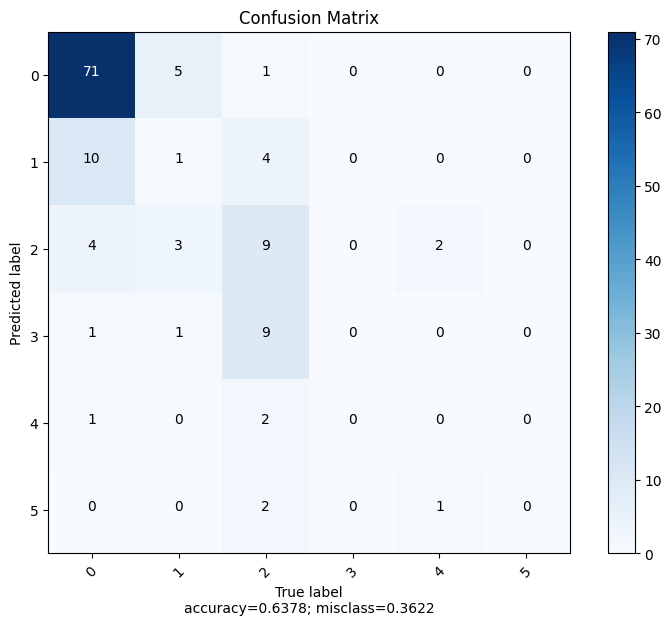

In [69]:
# plot confusion matrix of predictions

confusion = confusion_matrix(y_test, predictions_lr)
plot_confusion_matrix(cm=confusion, target_names=[i for i in range(6)], title = 'Confusion Matrix',normalize=False)


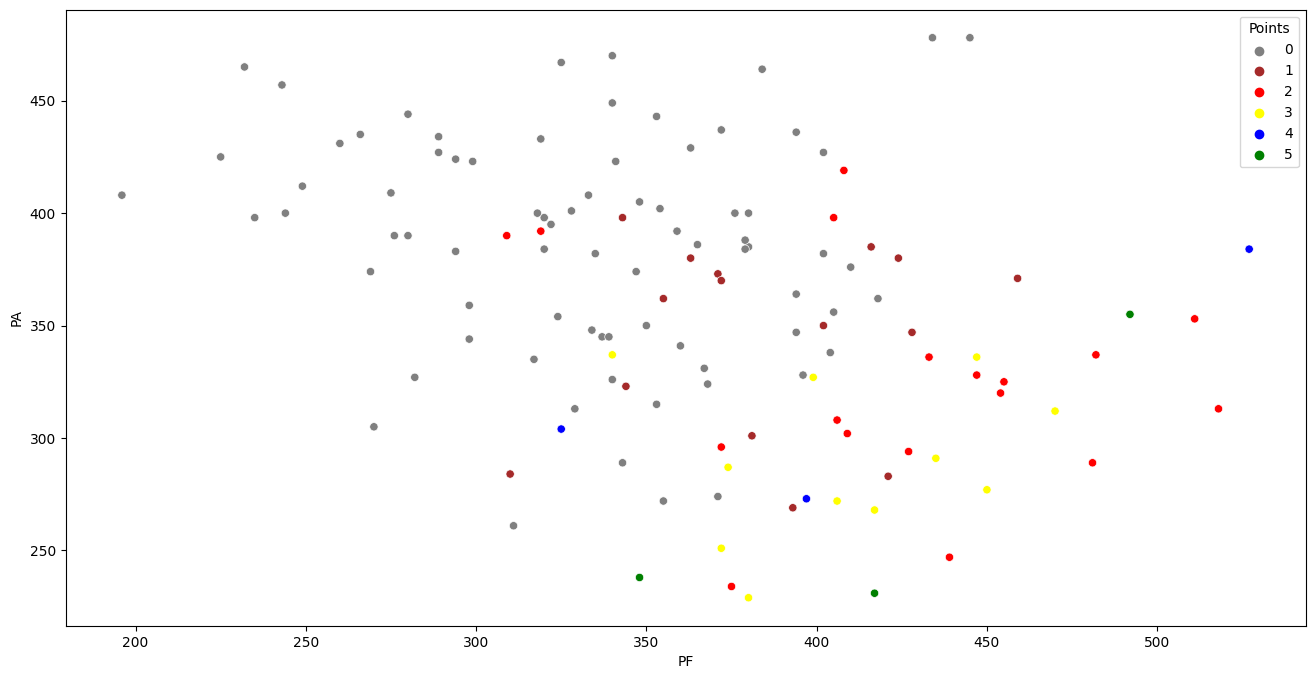

In [39]:
fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1,1)
sns.scatterplot(x = 'PF', y='PA', data=X_test,  hue=y_test,palette=['gray','brown','red','yellow','blue','green'])
#ax.set_ylim(3000, 8000)
#ax.set_xlim(15, 50)
plt.show()

In [70]:
# Accuracy scores

acc_train = lr.score(X_train, y_train)
print("Accuracy on train = %0.4f " % acc_train)

acc_test = lr.score(X_test, y_test)
print("Accuracy on test = %0.4f " % acc_test)

Accuracy on train = 0.6845 
Accuracy on test = 0.6378 


### **Decision Tree**

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

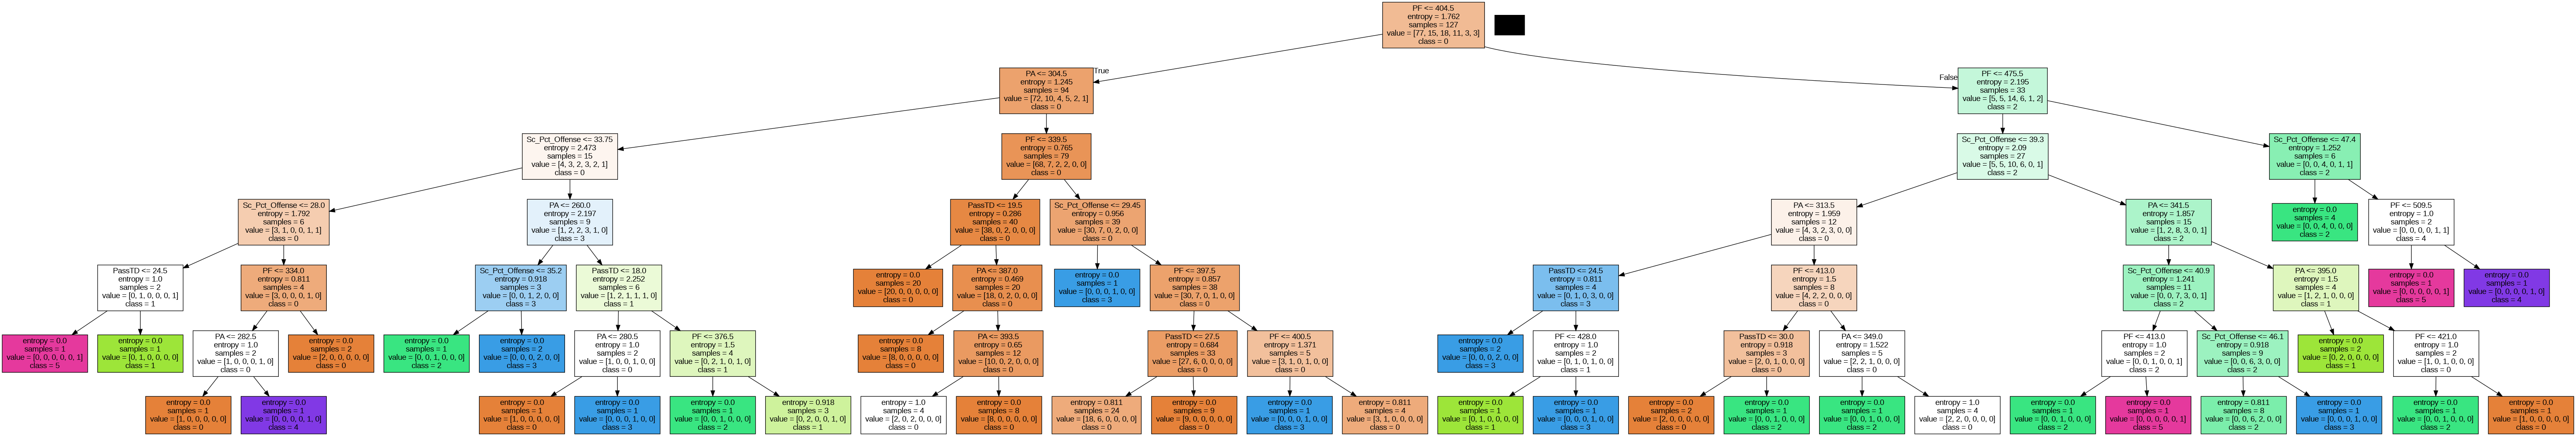

In [72]:
# This is the model that you'll be using
from sklearn import tree

# A convenience for displaying visualizations
from IPython.display import Image

# Packages for rendering the tree
import pydotplus
import graphviz

# Initialize and train the tree
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=6,
    random_state = 1337
)
Tree = decision_tree.fit(X_test, y_test)

# Render the tree
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X_test.columns,
    class_names=['0', '1','2', '3','4', '5'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [73]:
# Show accuracy scores

acc_train = Tree.score(X_train, y_train)
print("Accuracy on train = %0.4f " % acc_train)

acc_test = Tree.score(X_test, y_test)
print("Accuracy on test = %0.4f " % acc_test)

Accuracy on train = 0.6151 
Accuracy on test = 0.8898 


In [74]:
Y_tree = Tree.predict(X_test)

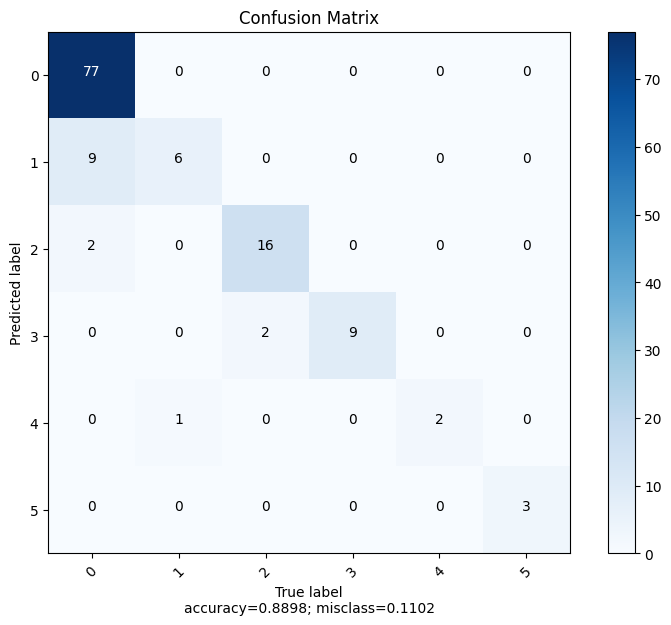

In [75]:
confusion = confusion_matrix(y_test, Y_tree)
plot_confusion_matrix(cm=confusion, target_names=[i for i in range(6)], title = 'Confusion Matrix',normalize=False)

### **Tuning Model Performance**

Decision Tree - depths = 8

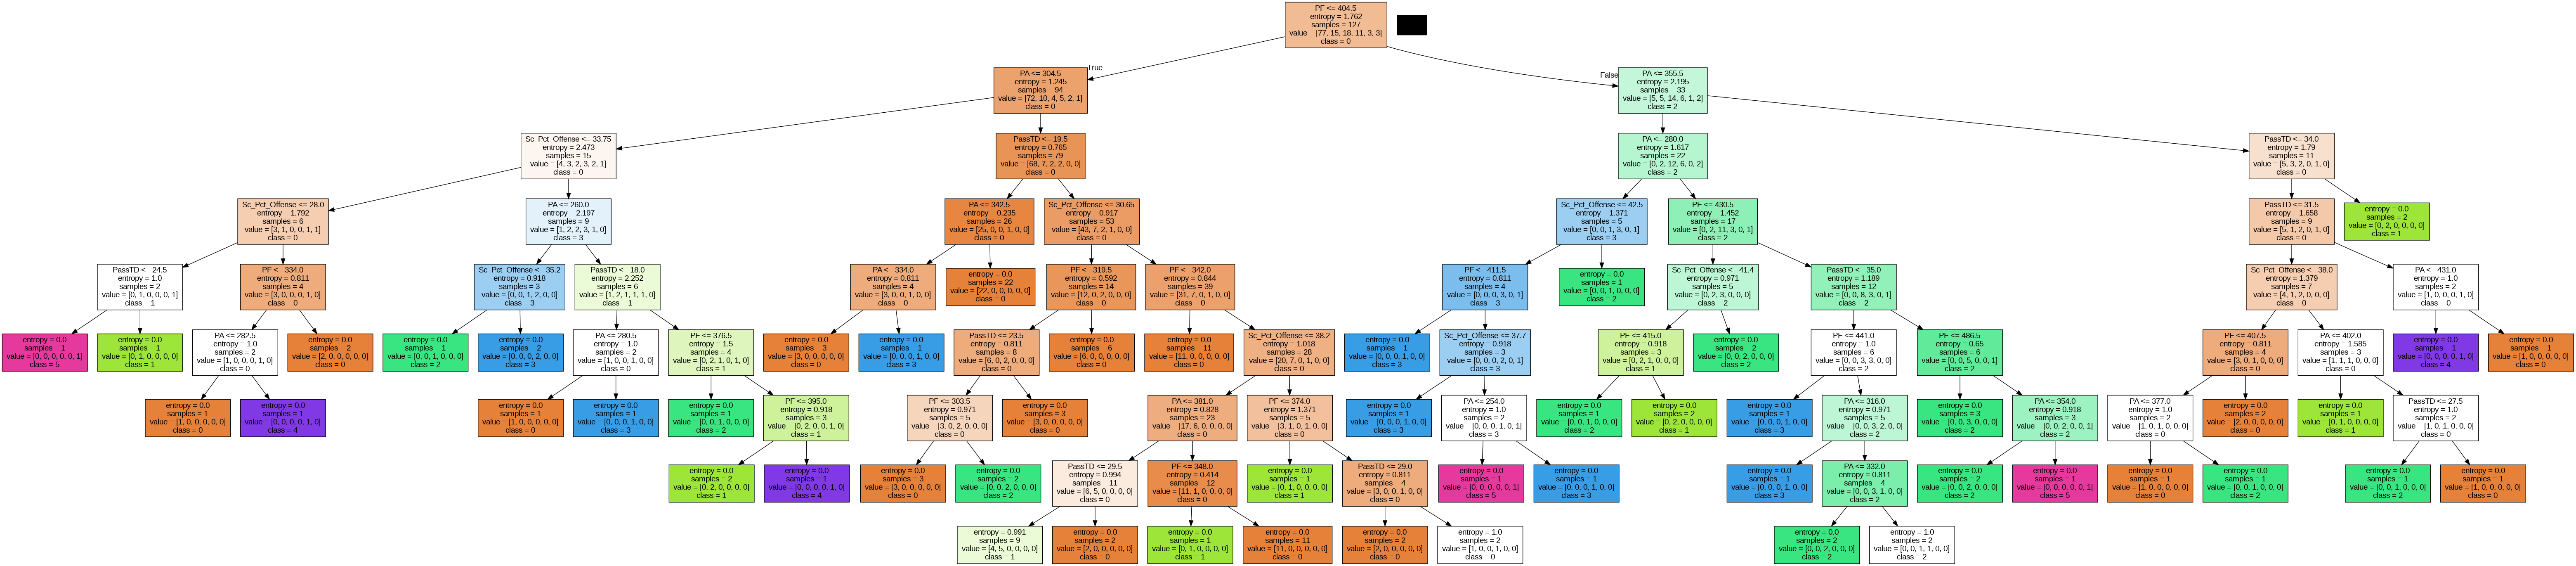

In [79]:
# Initialize and train the tree
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=8,
    random_state = 1337
)
Tree8 = decision_tree.fit(X_test, y_test)

# Render the tree
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X_test.columns,
    class_names=['0', '1','2', '3','4', '5'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [80]:
# Show accuracy scores
Y_tree8 = Tree8.predict(X_test)

acc_train = Tree8.score(X_train, y_train)
print("Accuracy on train = %0.4f " % acc_train)

acc_test = Tree8.score(X_test, y_test)
print("Accuracy on test = %0.4f " % acc_test)

Accuracy on train = 0.5496 
Accuracy on test = 0.9528 


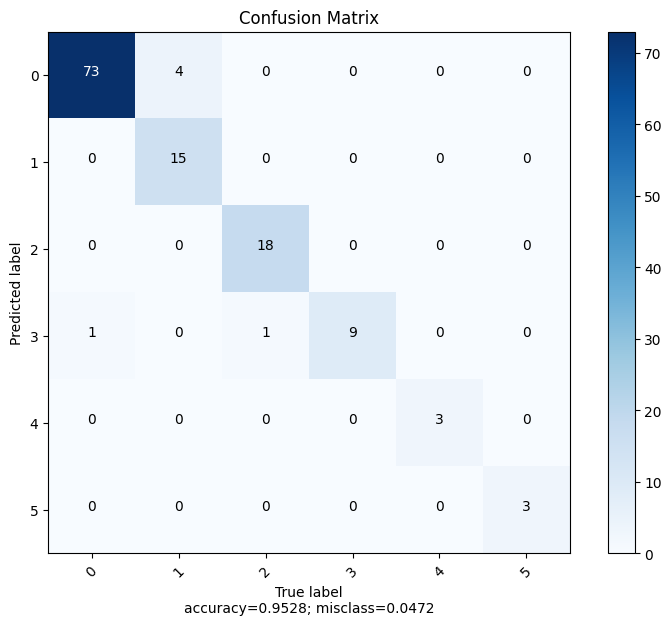

In [81]:
confusion = confusion_matrix(y_test, Y_tree8)
plot_confusion_matrix(cm=confusion, target_names=[i for i in range(6)], title = 'Confusion Matrix',normalize=False)

Decision Tree - depths = 4

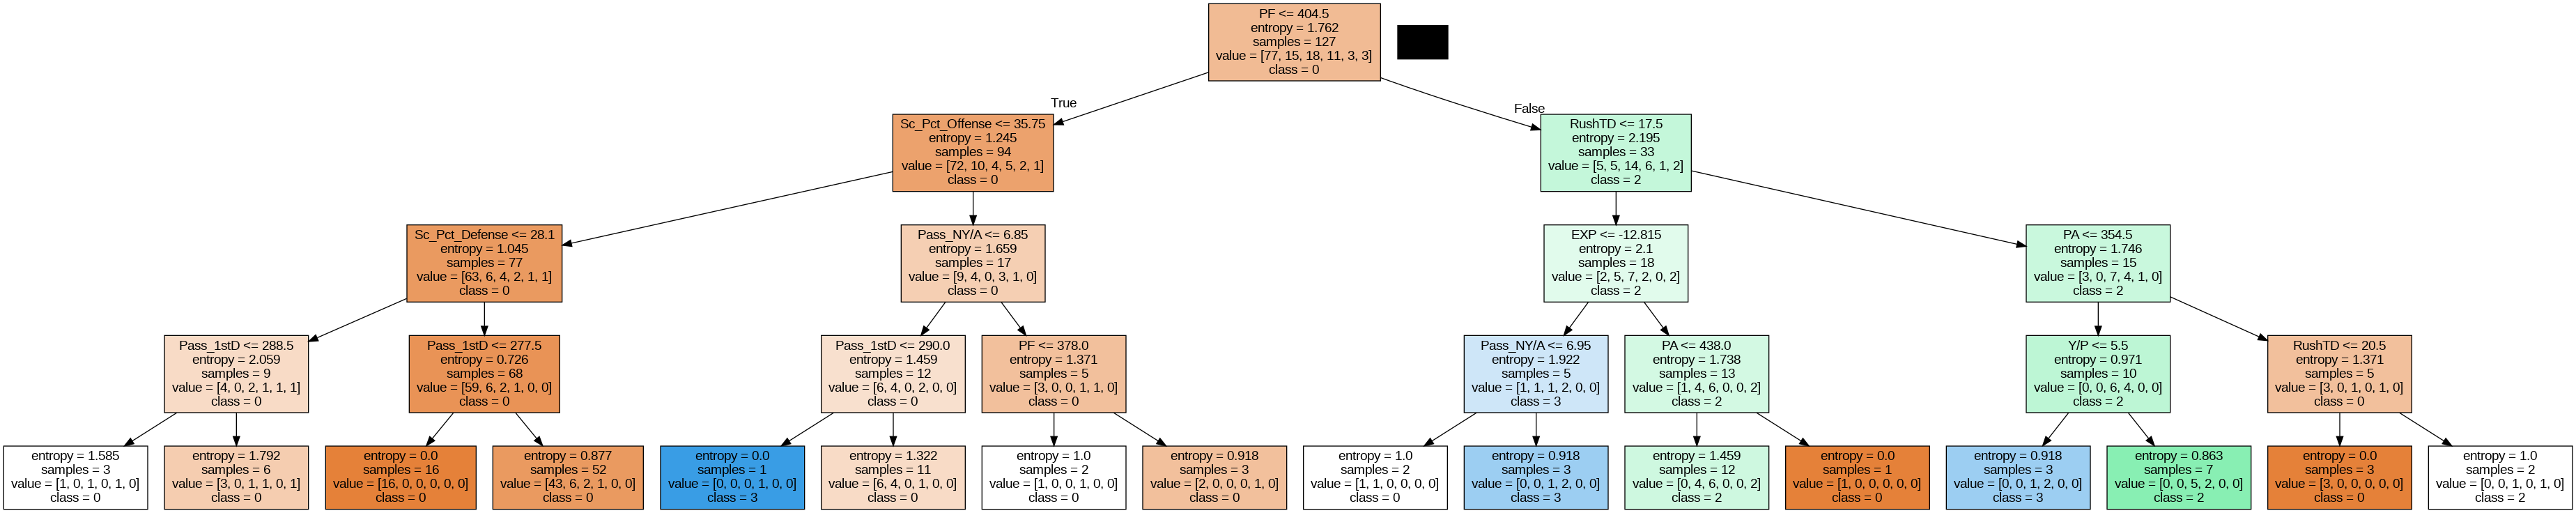

In [49]:
# Initialize and train the tree
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4,
    random_state = 1337
)
Tree4 = decision_tree.fit(X_test, y_test)

# Render the tree
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X_test.columns,
    class_names=['0', '1','2', '3','4', '5'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [50]:
# Show accuracy scores
Y_tree4 = Tree4.predict(X_test)

acc_train = Tree4.score(X_train, y_train)
print("Accuracy on train = %0.4f " % acc_train)

acc_test = Tree4.score(X_test, y_test)
print("Accuracy on test = %0.4f " % acc_test)

Accuracy on train = 0.6329 
Accuracy on test = 0.7402 


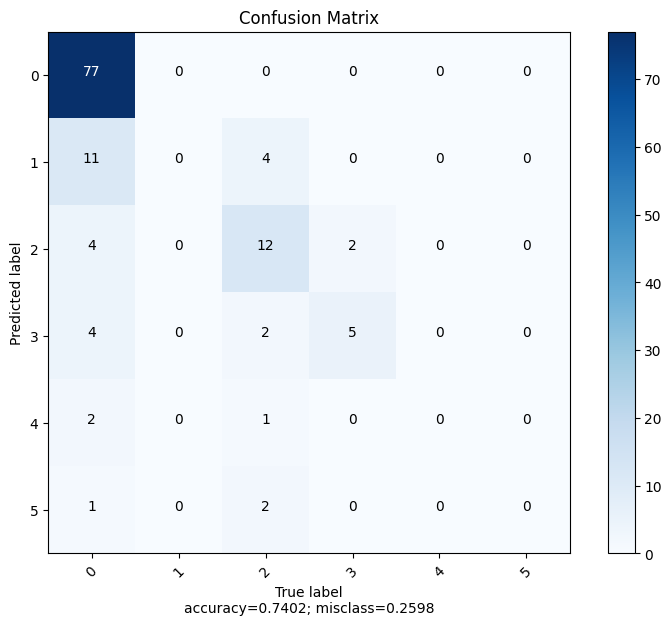

In [51]:
confusion = confusion_matrix(y_test, Y_tree4)
plot_confusion_matrix(cm=confusion, target_names=[i for i in range(6)], title = 'Confusion Matrix',normalize=False)

### **Testing on the 2002 Season**

In [76]:
playoff_results_2002 = playoff_results_by_year(2002)

playoff_results_cleaned_2002 = playoff_results_2002.replace({'Tm': new_team_names})

playoff_results_cleaned_2002

,Year,Points,Tm
227,2002,1,Green Bay Packers
228,2002,1,Indianapolis Colts
229,2002,1,Cleveland Browns
230,2002,1,New York Giants
231,2002,2,Pittsburgh Steelers
232,2002,2,Atlanta Falcons
233,2002,2,New York Jets
234,2002,2,San Francisco 49ers
235,2002,3,Tennessee Titans
236,2002,3,Philadelphia Eagles


In [53]:
# import 2002 offense
worksheet_offense_2002 = gc.open('2002 Offense').sheet1
#get_all_values gives a list of rows
rows_offense_2002 = worksheet_offense_2002.get_all_values()

offense_2002 = pd.DataFrame(rows_offense_2002)

# Make first row the column headers
offense_2002.columns = offense_2002.iloc[0]
offense_2002 = offense_2002.iloc[1:]

# import 2002 defense
worksheet_defense_2002 = gc.open('2002 Defense').sheet1
#get_all_values gives a list of rows
rows_defense_2002 = worksheet_defense_2002.get_all_values()

defense_2002 = pd.DataFrame(rows_defense_2002)

# Make first row the column headers
defense_2002.columns = defense_2002.iloc[0]
defense_2002 = defense_2002.iloc[1:]

# Clean offense of any name changes

# dictionary of new team names
new_team_names = {'Oakland Raiders': 'Las Vegas Raiders','San Diego Chargers': 'Los Angeles Chargers', 'St. Louis Rams': 'Los Angeles Rams', 'Washington Redskins' : 'Washington Commanders','Washington Football Team':'Washington Commanders'}

offense_cleaned_2002 = offense_2002.replace({'Tm': new_team_names})

defense_cleaned_2002 = defense_2002.replace({'Tm': new_team_names})

offense_cleaned_2002

,Year,Tm,G,PA,Total_Yds,Ply,Y/P,TO,Pass_1stD,PassYds,...,Pass_NY/A,Rush1stD,RushYds,RushTD,RushY/A,Pen_Offense,1stPy,Sc_Pct_Offense,TO_Pct_Offense,EXP
1,2002,Tampa Bay Buccaneers,16,196,4044,963,4.2,38,236,2490,...,4.5,131,1554,8,3.8,93,26,17.8,18.3,284.7
2,2002,Philadelphia Eagles,16,241,4754,1009,4.7,38,272,3094,...,5,160,1660,5,4.3,112,29,20.6,18,173.69
3,2002,New York Giants,16,279,4949,985,5,25,266,3119,...,5.4,162,1830,12,4.5,120,17,27,12.4,63.16
4,2002,Miami Dolphins,16,301,4656,974,4.8,30,285,3102,...,5.5,162,1554,9,3.8,106,37,30.3,14.4,117.76
5,2002,Carolina Panthers,16,302,4646,1022,4.5,33,271,2993,...,5.2,155,1653,12,3.7,98,21,25.5,14.2,123.24
6,2002,Las Vegas Raiders,16,304,4979,997,5,31,319,3526,...,5.8,189,1453,14,3.8,103,34,28.7,16.6,96.65
7,2002,Indianapolis Colts,16,313,4909,963,5.1,27,279,2917,...,5.8,148,1992,16,4.3,102,17,31.5,12.4,10.05
8,2002,Atlanta Falcons,16,314,5334,1002,5.3,39,288,3287,...,5.9,171,2047,12,4.6,112,20,27.9,19.5,44.99
9,2002,Jacksonville Jaguars,16,315,5335,1042,5.1,27,324,3264,...,5.9,188,2071,14,4.3,96,24,31.8,14.8,13.57
10,2002,Cleveland Browns,16,320,5348,1024,5.2,29,291,3269,...,6,164,2079,12,4.3,91,20,31.7,13.2,-16.3


In [54]:
# Append Offensive data and Defensive Data to create a list of all possible features

stats_2002 = pd.merge(offense_cleaned_2002, defense_cleaned_2002, on=["Year","Tm"])

stats_2002

,Year,Tm,G_x,PA,Total_Yds,Ply,Y/P,TO,Pass_1stD,PassYds,...,Int,PassNY/A_Allowed,RushYds_Allowed,RushTD_Allowed,RushY/A_Allowed,Defensive_Pen,1stPy_Allowed,Sc_Pct_Defense,TO_Pct_Defense,EXP_Pts_Allowed
0,2002,Tampa Bay Buccaneers,16,196,4044,963,4.2,38,236,2490,...,10,5.7,1557,6,3.8,103,25,32.6,10.7,-43.76
1,2002,Philadelphia Eagles,16,241,4754,1009,4.7,38,272,3094,...,11,5.8,2220,15,4.5,111,23,36,12,-15.34
2,2002,New York Giants,16,279,4949,985,5,25,266,3119,...,14,6.9,1875,14,3.9,113,33,31.2,13.8,3.07
3,2002,Miami Dolphins,16,301,4656,974,4.8,30,285,3102,...,15,6,2502,24,4.7,103,24,34.6,15.7,-18.71
4,2002,Carolina Panthers,16,302,4646,1022,4.5,33,271,2993,...,22,5.3,1586,11,3.5,94,23,19.4,17.5,-165.57
5,2002,Las Vegas Raiders,16,304,4979,997,5,31,319,3526,...,10,6.8,1762,21,4.3,129,27,42.7,9.4,123.35
6,2002,Indianapolis Colts,16,313,4909,963,5.1,27,279,2917,...,19,6.6,1561,12,3.6,91,18,33.9,16.4,-4.6
7,2002,Atlanta Falcons,16,314,5334,1002,5.3,39,288,3287,...,12,6.1,2368,23,4.5,105,30,38.6,13.2,38.4
8,2002,Jacksonville Jaguars,16,315,5335,1042,5.1,27,324,3264,...,9,5.5,2089,19,4.6,89,14,31.5,7.9,0.42
9,2002,Cleveland Browns,16,320,5348,1024,5.2,29,291,3269,...,22,5.8,1615,10,4,107,31,30.9,15.2,-34.95


In [55]:
# Create df with all playoff results

stats_with_results_2002 = pd.merge(stats_2002, playoff_results_cleaned_2002, on=["Year", "Tm"],how="outer")

# Replace all NaN in the points column with 0. These are teams that didn't make the playoffs

stats_with_results_cleaned_2002 = stats_with_results_2002.fillna(0)

cols_to_numeric = stats_with_results_cleaned_2002.columns.drop('Tm')

stats_with_results_cleaned_2002[cols_to_numeric] = stats_with_results_cleaned_2002[cols_to_numeric].apply(pd.to_numeric, errors='coerce')

stats_with_results_cleaned_2002

,Year,Tm,G_x,PA,Total_Yds,Ply,Y/P,TO,Pass_1stD,PassYds,...,PassNY/A_Allowed,RushYds_Allowed,RushTD_Allowed,RushY/A_Allowed,Defensive_Pen,1stPy_Allowed,Sc_Pct_Defense,TO_Pct_Defense,EXP_Pts_Allowed,Points
0,2002,Tampa Bay Buccaneers,16,196,4044,963,4.2,38,236,2490,...,5.7,1557,6,3.8,103,25,32.6,10.7,-43.76,5
1,2002,Philadelphia Eagles,16,241,4754,1009,4.7,38,272,3094,...,5.8,2220,15,4.5,111,23,36.0,12.0,-15.34,3
2,2002,New York Giants,16,279,4949,985,5.0,25,266,3119,...,6.9,1875,14,3.9,113,33,31.2,13.8,3.07,1
3,2002,Miami Dolphins,16,301,4656,974,4.8,30,285,3102,...,6.0,2502,24,4.7,103,24,34.6,15.7,-18.71,0
4,2002,Carolina Panthers,16,302,4646,1022,4.5,33,271,2993,...,5.3,1586,11,3.5,94,23,19.4,17.5,-165.57,0
5,2002,Las Vegas Raiders,16,304,4979,997,5.0,31,319,3526,...,6.8,1762,21,4.3,129,27,42.7,9.4,123.35,4
6,2002,Indianapolis Colts,16,313,4909,963,5.1,27,279,2917,...,6.6,1561,12,3.6,91,18,33.9,16.4,-4.60,1
7,2002,Atlanta Falcons,16,314,5334,1002,5.3,39,288,3287,...,6.1,2368,23,4.5,105,30,38.6,13.2,38.40,2
8,2002,Jacksonville Jaguars,16,315,5335,1042,5.1,27,324,3264,...,5.5,2089,19,4.6,89,14,31.5,7.9,0.42,0
9,2002,Cleveland Browns,16,320,5348,1024,5.2,29,291,3269,...,5.8,1615,10,4.0,107,31,30.9,15.2,-34.95,1


In [77]:
factors_2022 = ['PF','PassTD','PA','Sc_Pct_Offense']


X_2022 = stats_with_results_cleaned_2002[factors_2022]
Y_2022 = stats_with_results_cleaned_2002.Points

In [82]:
Y_Tree8_2022 = Tree8.predict(X_2022)

stats_with_results_cleaned_2002['PREDICTED RESULTS'] = Y_Tree8_2022

stats_with_results_cleaned_2002[['Year','Tm','Points','PREDICTED RESULTS']]


,Year,Tm,Points,PREDICTED RESULTS
0,2002,Tampa Bay Buccaneers,5,5
1,2002,Philadelphia Eagles,3,3
2,2002,New York Giants,1,5
3,2002,Miami Dolphins,0,0
4,2002,Carolina Panthers,0,5
5,2002,Las Vegas Raiders,4,3
6,2002,Indianapolis Colts,1,0
7,2002,Atlanta Falcons,2,0
8,2002,Jacksonville Jaguars,0,0
9,2002,Cleveland Browns,1,1


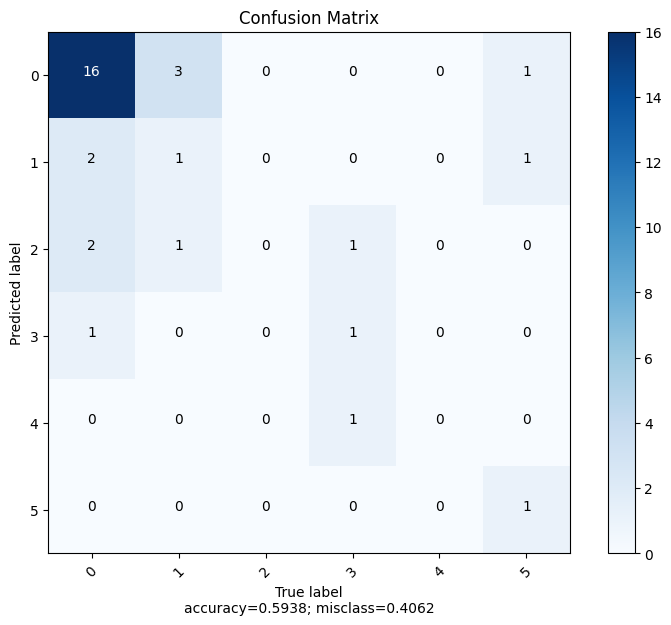

In [83]:
confusion = confusion_matrix(Y_2022, Y_Tree8_2022)
plot_confusion_matrix(cm=confusion, target_names=[i for i in range(6)], title = 'Confusion Matrix',normalize=False)